In [3]:
from __future__ import print_function
from preprocessing import read_data, articles_from_csv_reader, dummy_str_reader, get_word_embeddings, subgraph, \
    graph_candidates
from visualize import visualize
import numpy as np
import spacy
import constants
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from IPython.display import Image
from IPython.display import display

In [4]:
data_dir = '/media/arne/DATA/DEVELOPING/ML/data/'

dim = 300
edge_count = 60
seq_length = 10

slice_size = 75
max_forest_count = 10

nlp = spacy.load('en')
nlp.pipeline = [nlp.tagger, nlp.parser]

In [5]:
vecs, mapping, human_mapping = get_word_embeddings(nlp.vocab)
data_embedding_maps = {constants.WORD_EMBEDDING: mapping}
data_embedding_maps_human = {constants.WORD_EMBEDDING: human_mapping}
data_vecs = {constants.WORD_EMBEDDING: vecs}

Total time running get_word_embeddings: 8.18480706215 seconds


In [6]:
# create data arrays
(seq_data, seq_types, seq_parents, seq_edges), edge_map = \
    read_data(articles_from_csv_reader, nlp, data_embedding_maps, max_forest_count=max_forest_count, max_sen_length=slice_size,
              args={'max_articles': 1, 'filename': data_dir + 'corpora/documents_utf8_filtered_20pageviews.csv'})

parse 1 articles
read article: wikipedia-23885690 ...  0 %
Total time running read_data: 0.202230930328 seconds


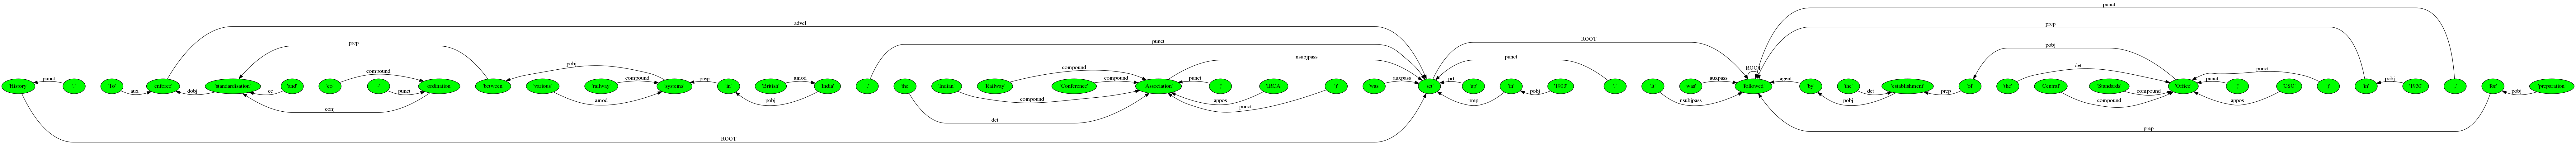

In [7]:
# take first 50 token and visualize the dependency graph
start = 0
end = 50
sliced_parents = subgraph(seq_parents, start, end)
sliced_data = seq_data[start:end]
sliced_types = seq_types[start:end]
sliced_edges = seq_edges[start:end]
visualize('forest.png', (sliced_data, sliced_types, sliced_parents, sliced_edges), data_embedding_maps_human, edge_map)
Image('forest.png')

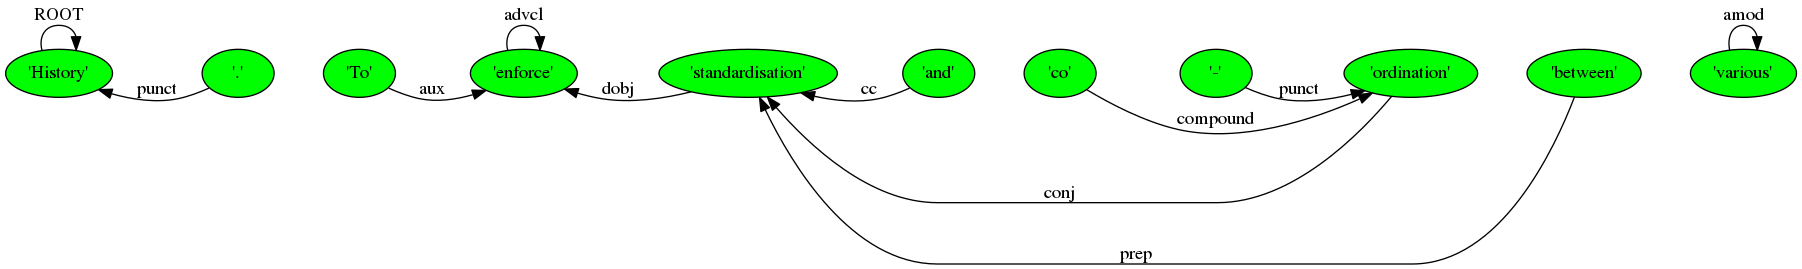

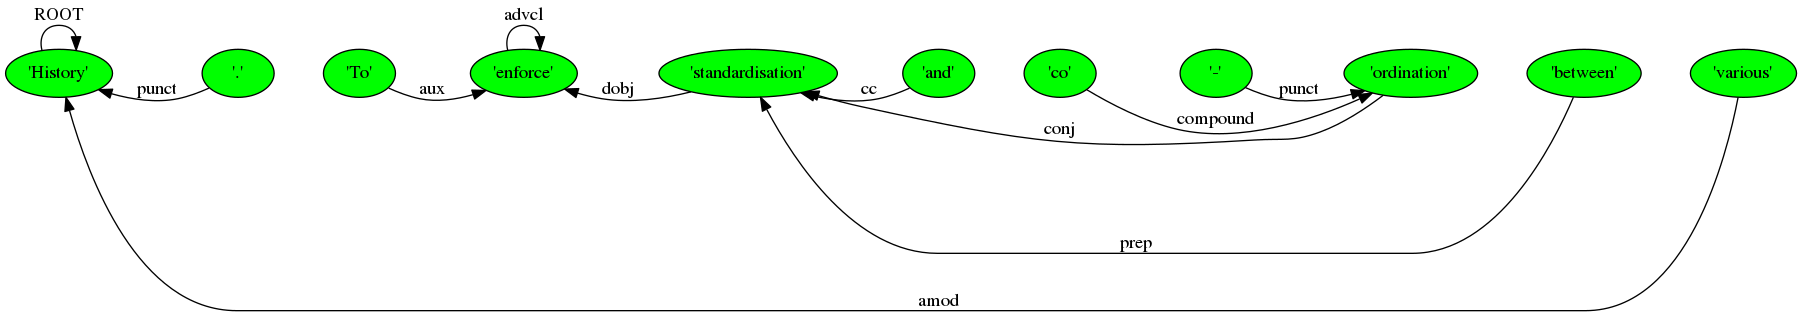

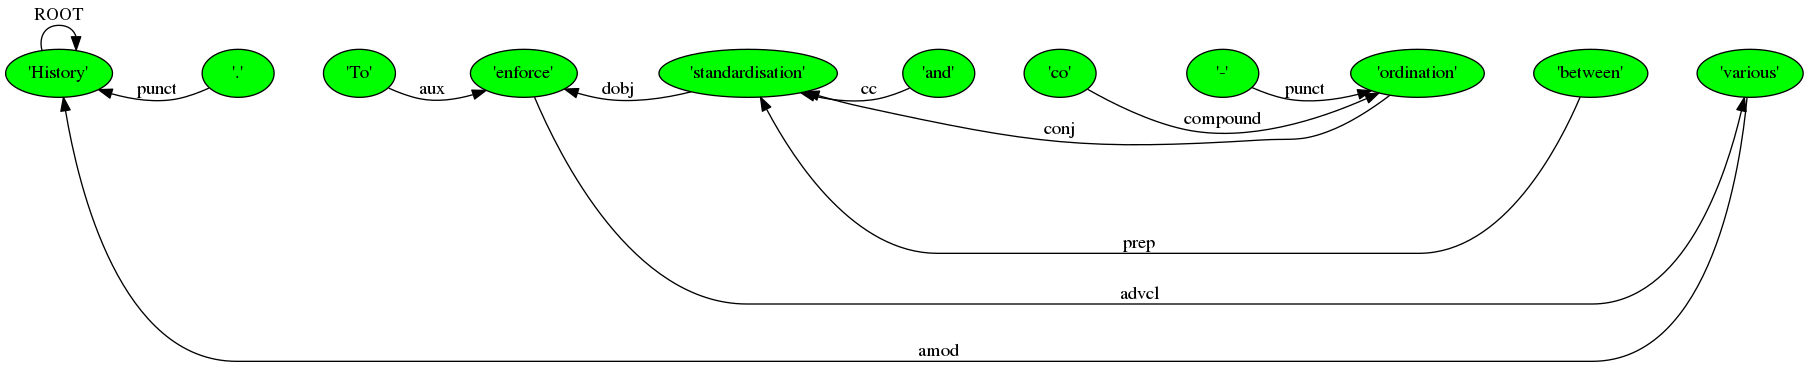

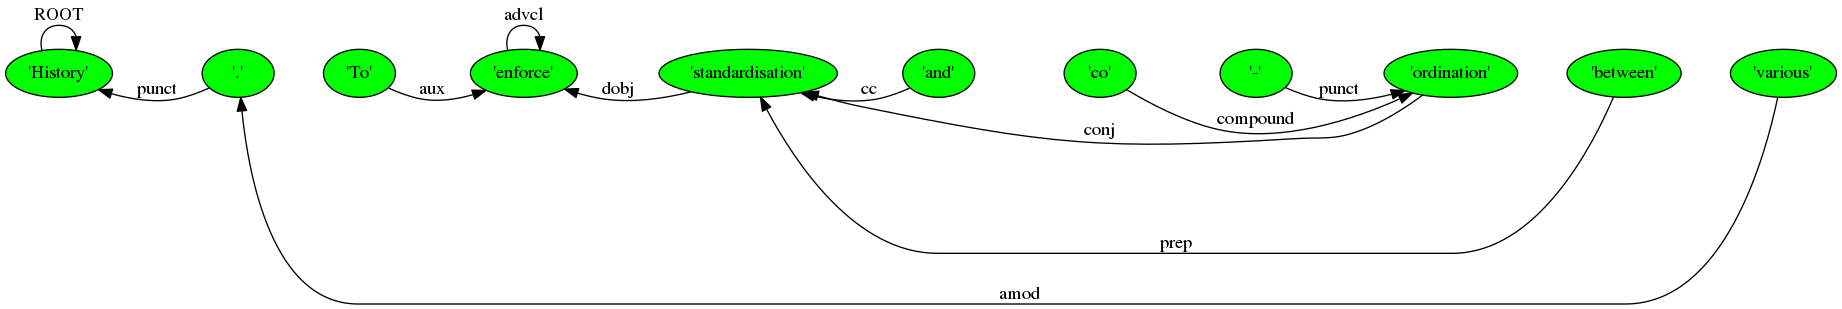

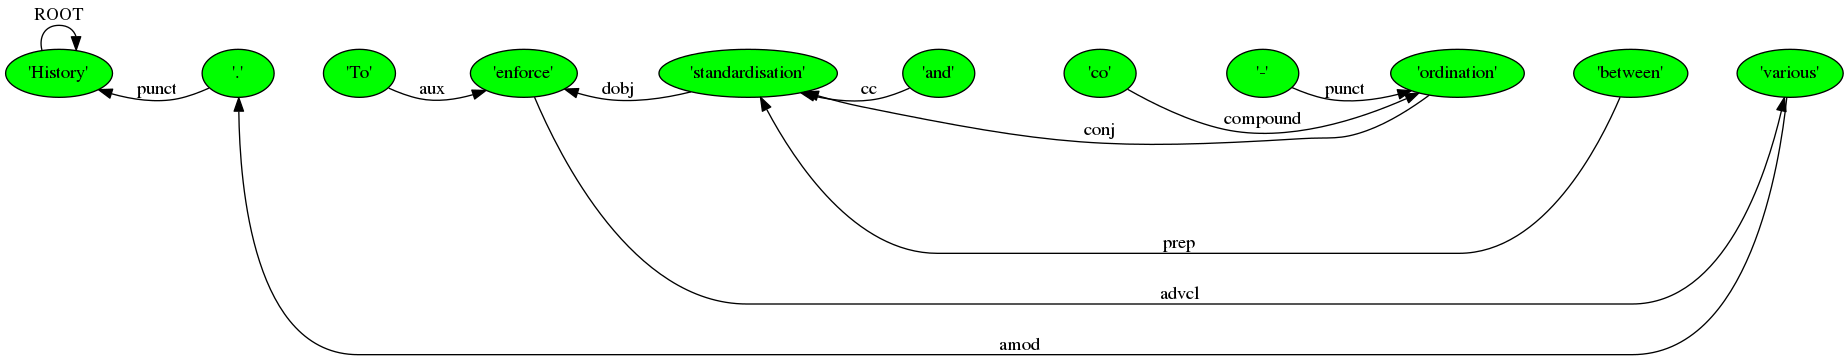

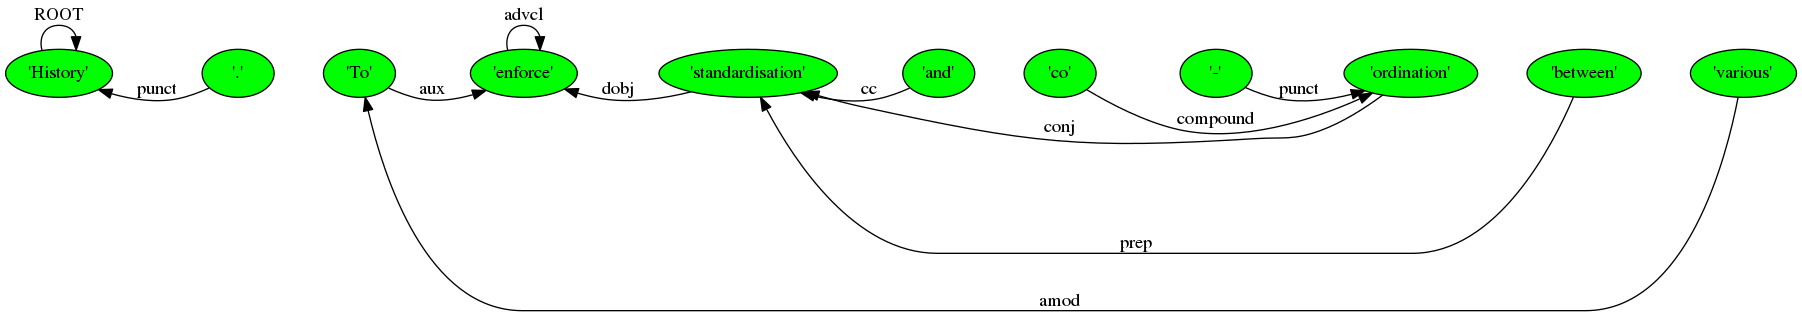

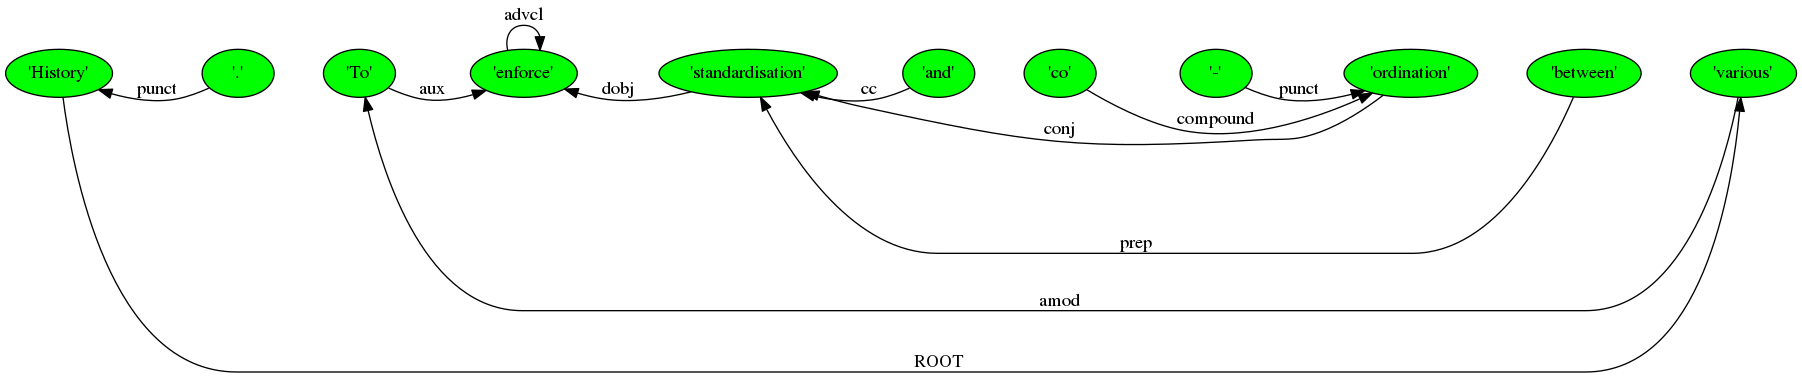

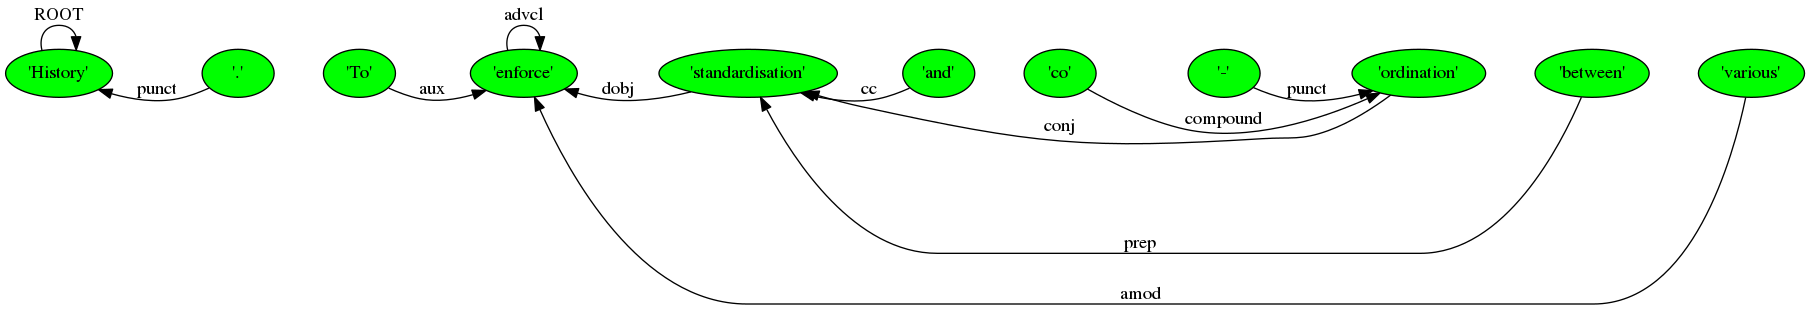

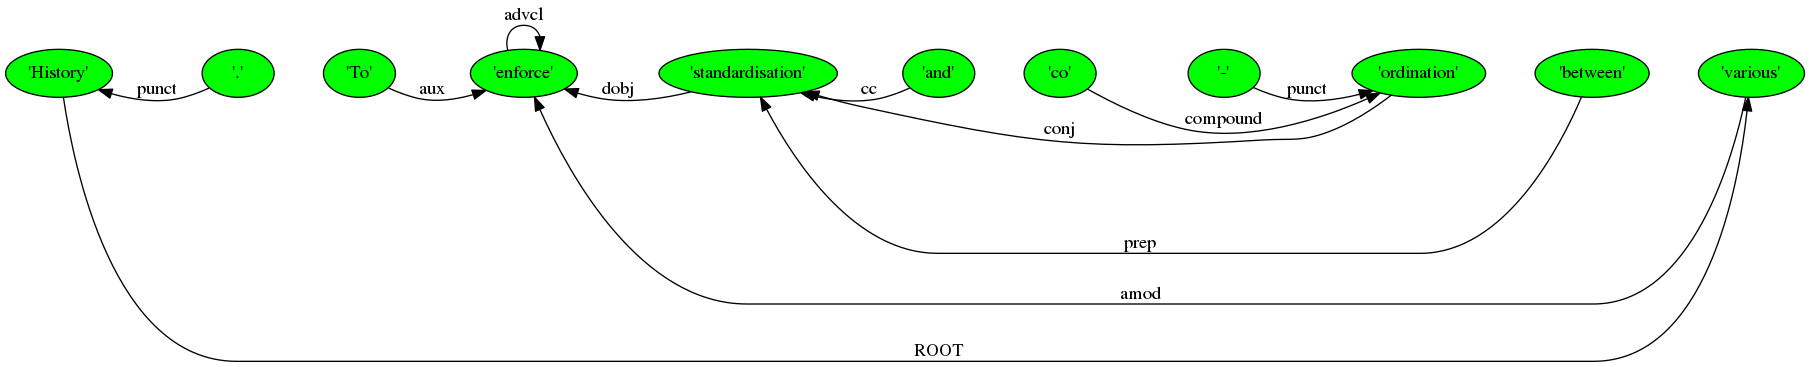

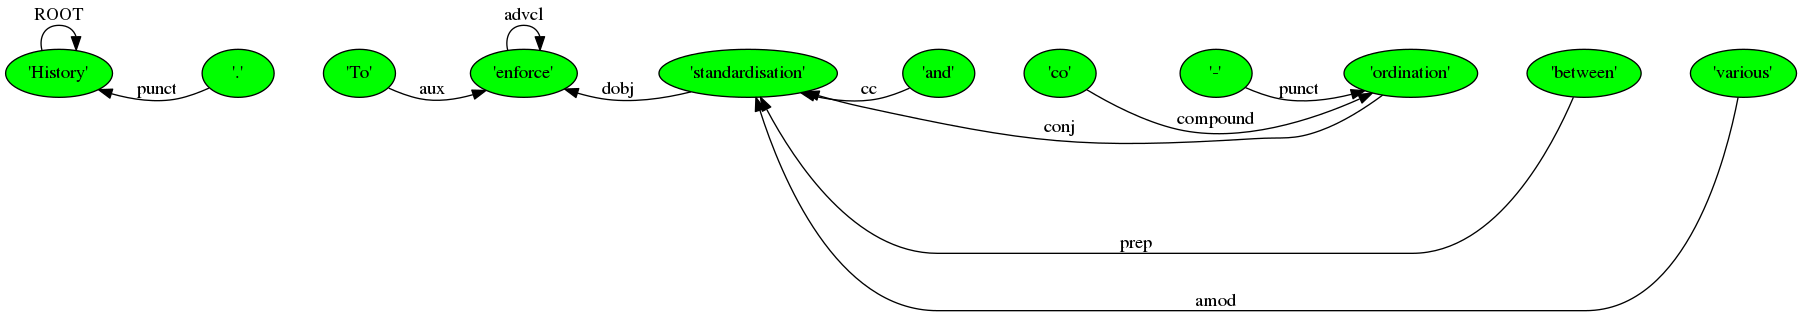

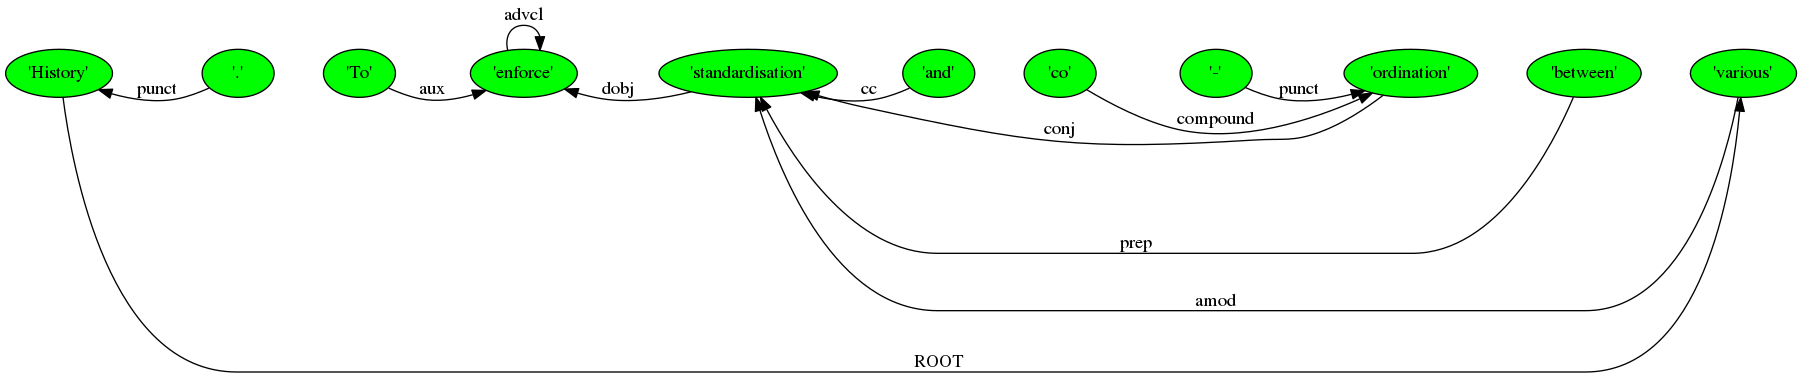

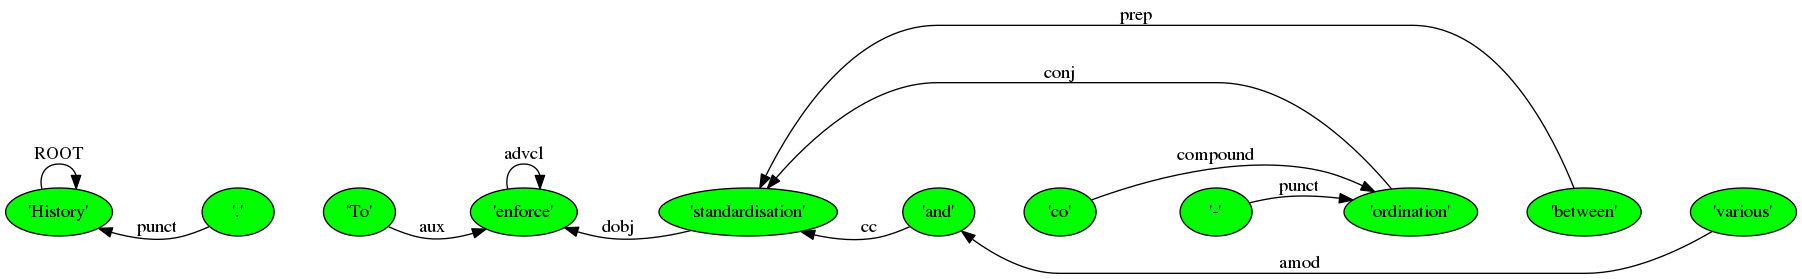

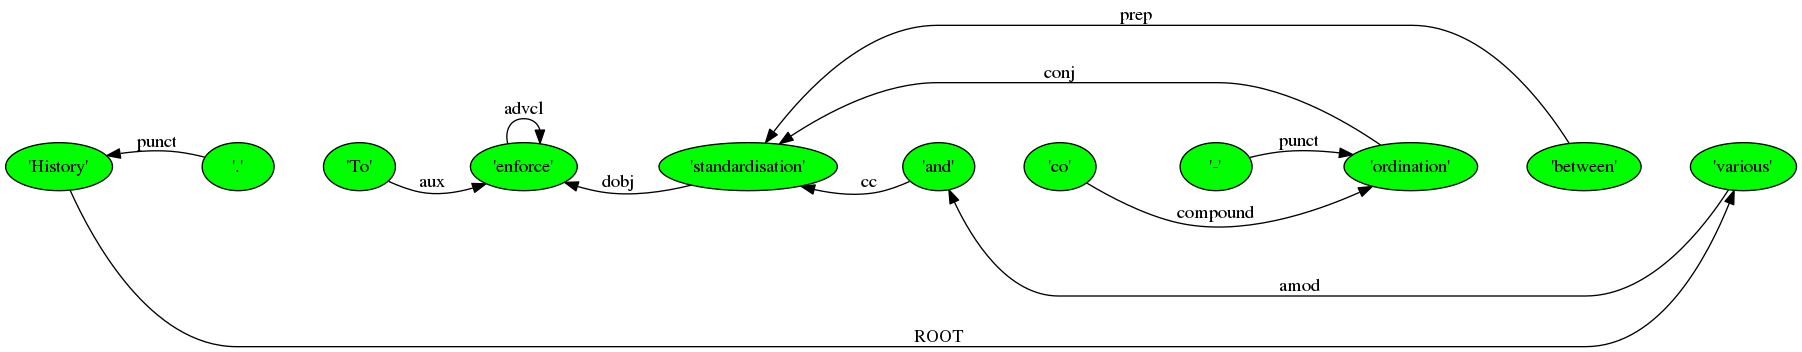

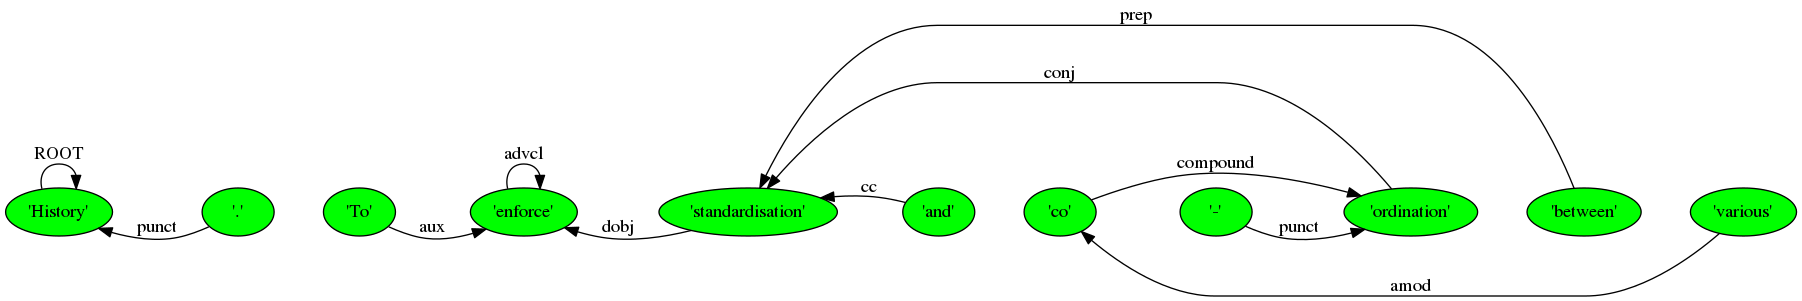

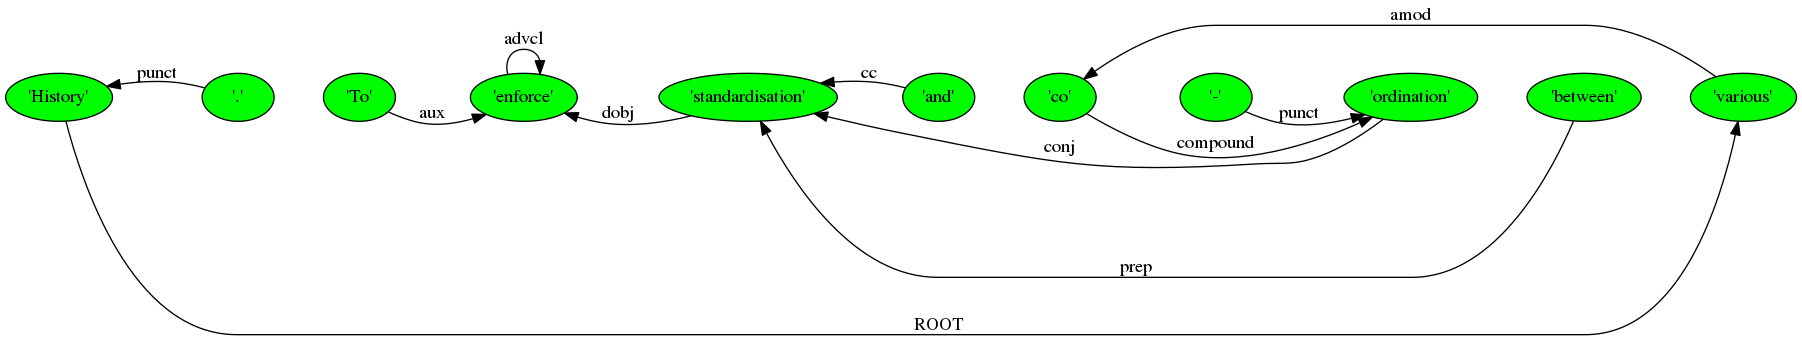

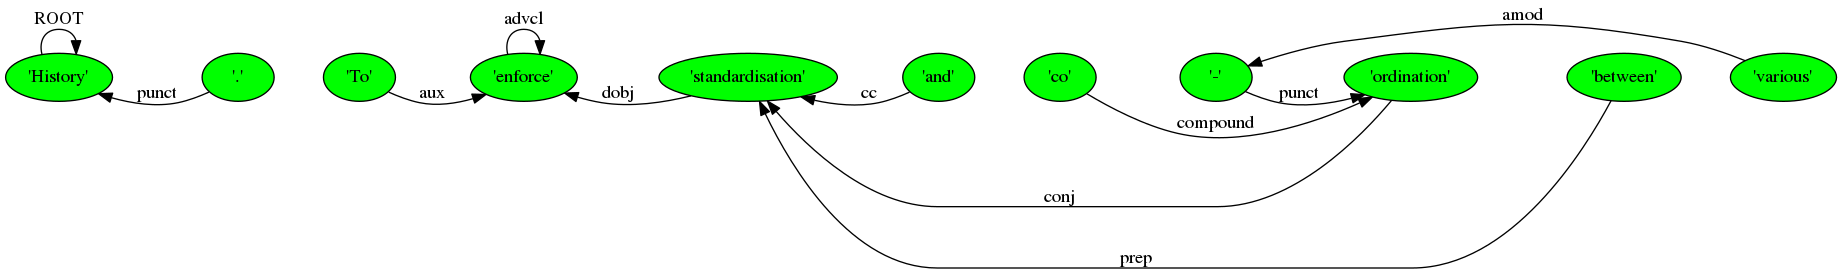

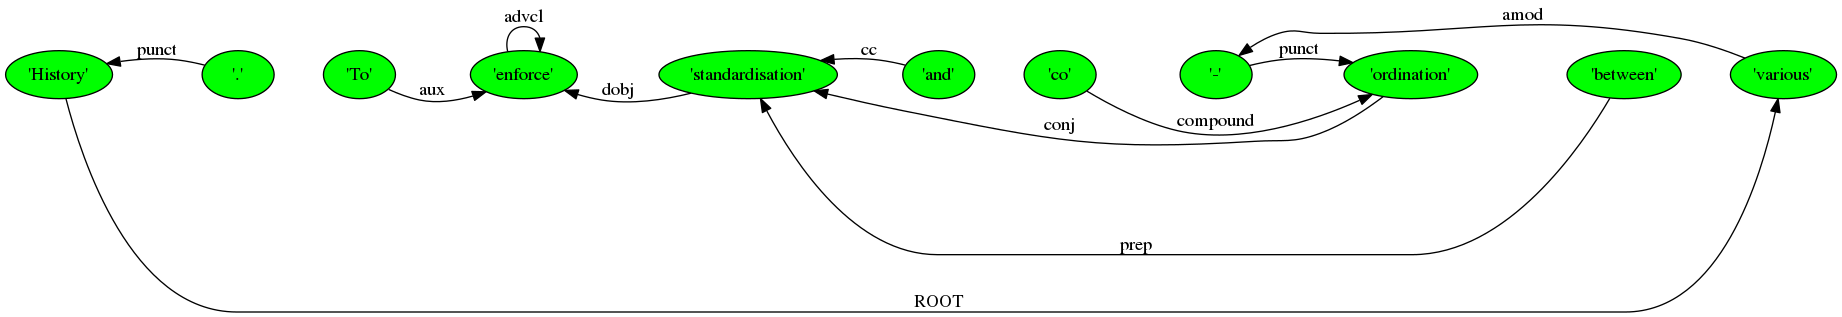

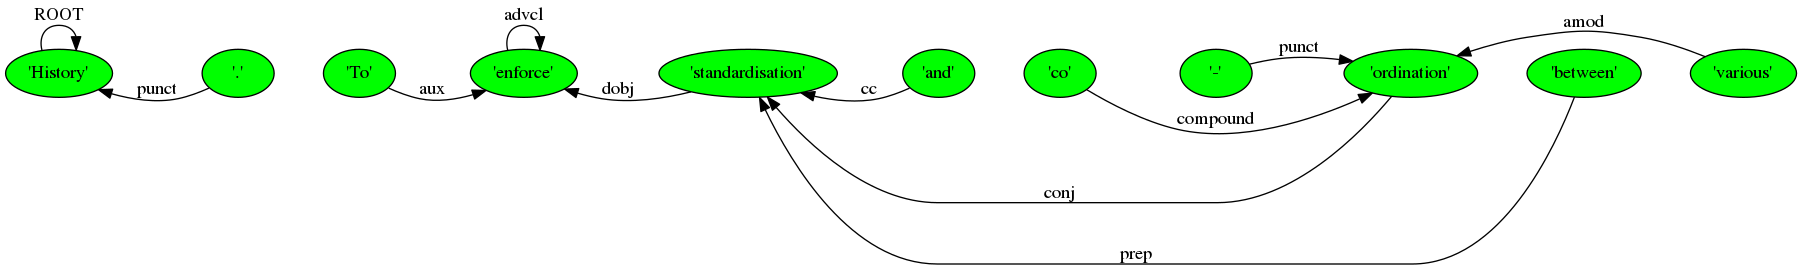

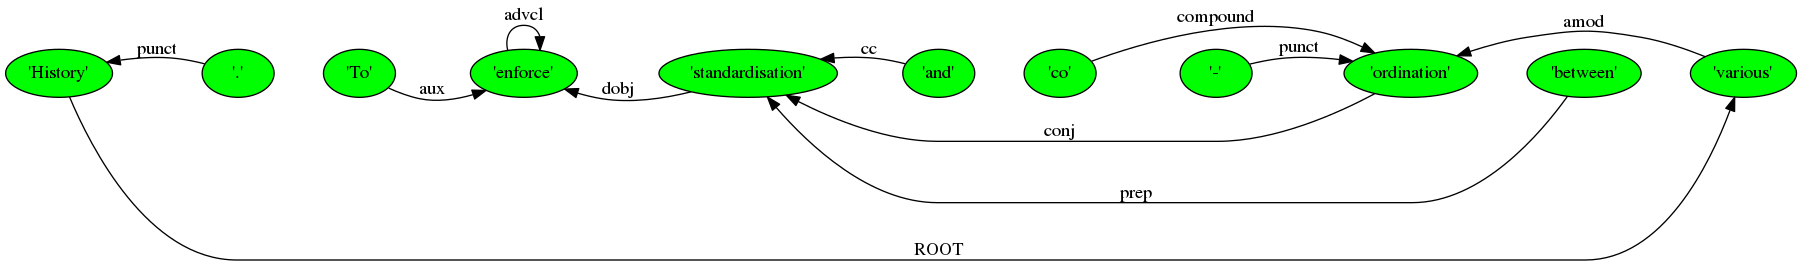

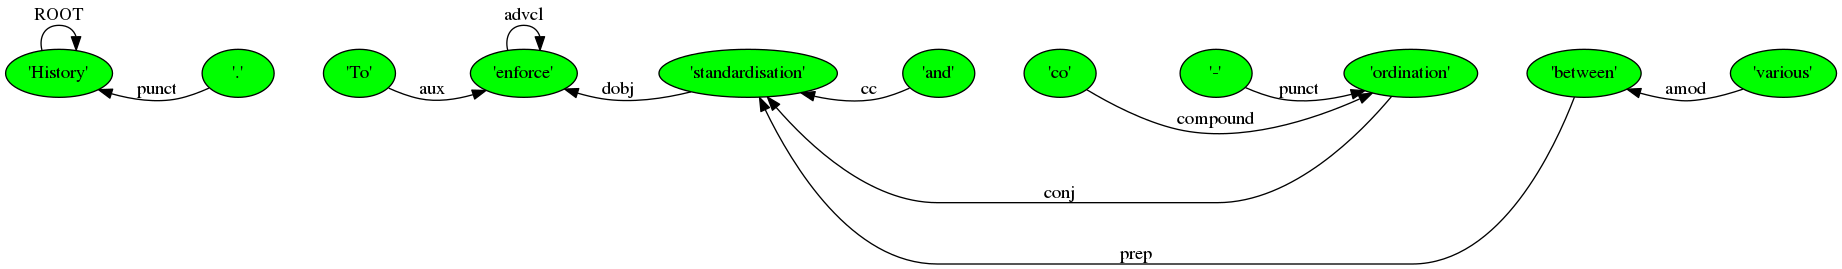

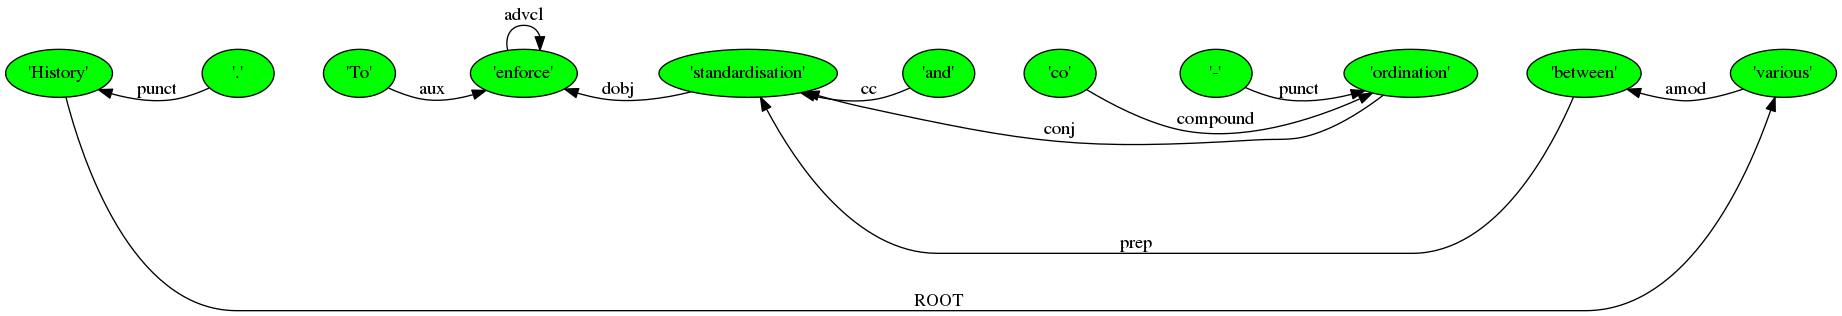

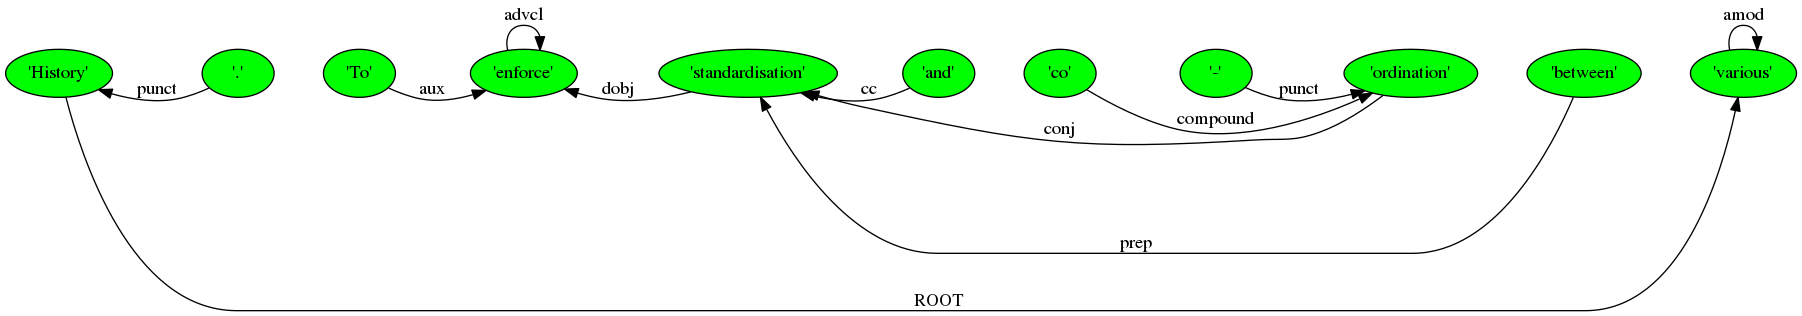

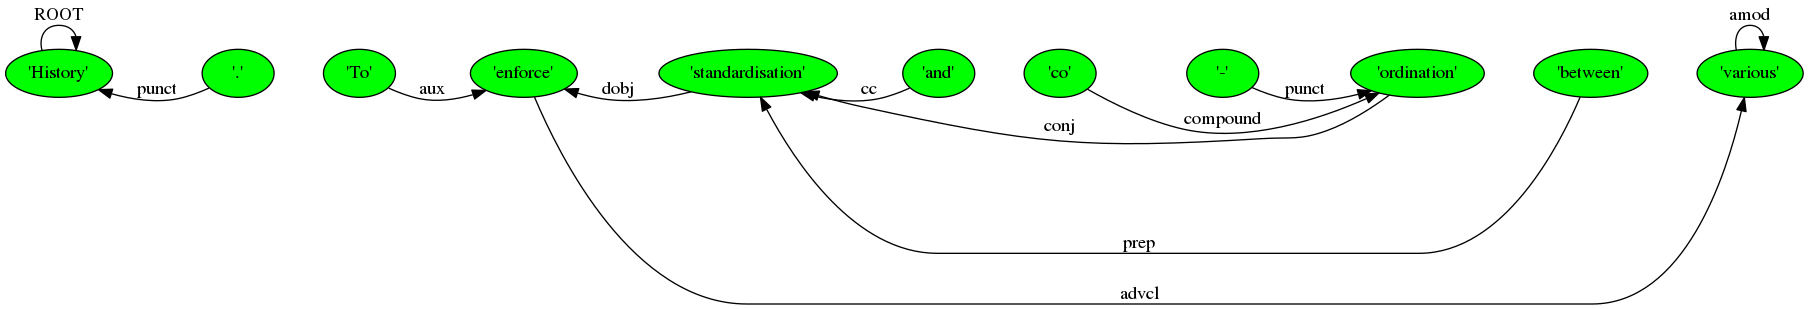

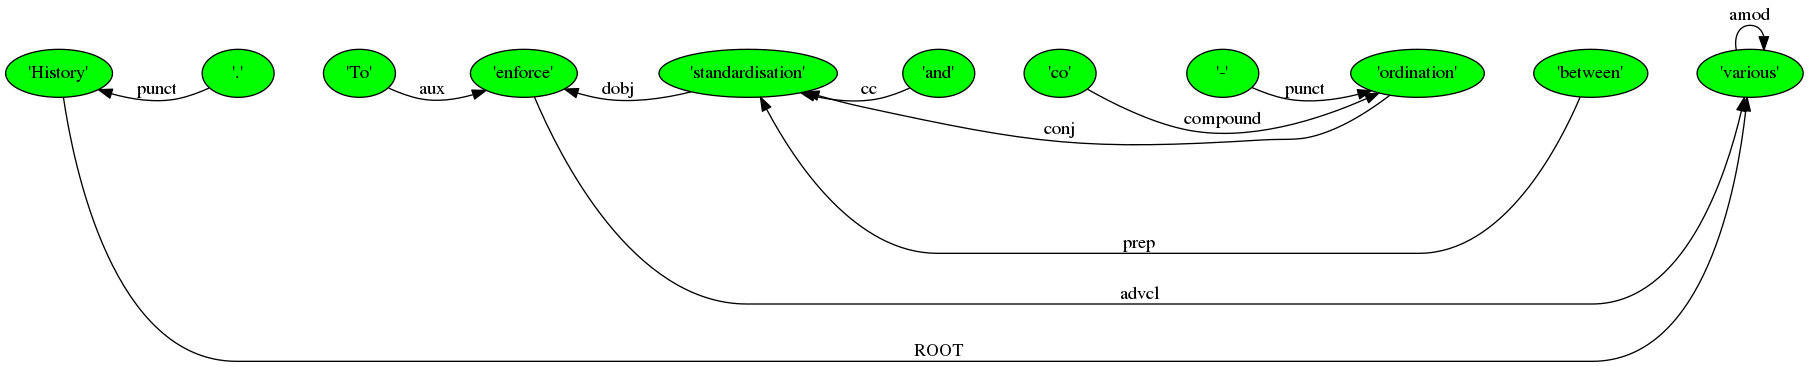

In [8]:
# create possible graphs (forests) for "new" data point with index = 9 (token: 'between')
ind = 10
graphs = graph_candidates(sliced_parents, ind)
for i, g in enumerate(graphs):
    fn = 'forest_'+str(i)+'.png'
    visualize(fn, (sliced_data[:(ind + 1)], sliced_types[:(ind + 1)], g, sliced_edges[:(ind + 1)]+[0]),
              data_embedding_maps_human, edge_map)
    img = Image(fn)
    display(img)

In [20]:
class Net(nn.Module):
    def __init__(self, data_vecs, edge_count, dim):
        super(Net, self).__init__()

        # dimension of embeddings
        self.dim = dim

        self.data_vecs = data_vecs
        self.data_weights = {}
        self.data_biases = {}
        for data_type in self.data_vecs.keys():
            vecs = data_vecs[data_type]
            _, vec_dim = vecs.shape
            self.data_weights[data_type] = Variable(torch.zeros(vec_dim, dim), requires_grad=True)
            self.data_biases[data_type] = Variable(torch.zeros(dim), requires_grad=True)

        self.edge_weights = {}
        self.edge_biases = {}
        for i in range(edge_count):
            self.edge_weights[data_type] = Variable(torch.zeros(dim, dim), requires_grad=True)
            self.edge_biases[data_type] = Variable(torch.zeros(dim), requires_grad=True)

        self.score_embedding_weights = Variable(torch.zeros(1, dim), requires_grad=True)
        self.score_embedding_biases = Variable(torch.zeros(dim), requires_grad=True)
        self.score_data_weights = Variable(torch.zeros(1, dim), requires_grad=True)
        self.score_data_biases = Variable(torch.zeros(dim), requires_grad=True)
        
        
    def calc_embedding(self, data, types, parents, edges):
        
        # connect roots
        roots = [i for i, parent in enumerate(parents) if parent == 0]
        for i in range(len(roots)-1):
            parents[roots[i]] = roots[i+1]
        
        # TODO: implement!
        
        # dummy result
        return Variable(torch.zeros(self.dim), requires_grad = True)
        
    def calc_score(self, embedding, data_embedding):
        return (self.score_embedding_biases + embedding) * self.score_embedding_weights \
            + (self.score_data_biases + embedding) * self.score_data_weights
        
    def forward(self, data, types, edges, graphs, pos):
        
        data_vec = torch.from_numpy(data[ind])
        data_embedding = data_vec * self.data_weights[types[pos]] + self.data_biases[types[pos]]
        correct_edge = edges[pos]
        
        embeddings = []
        scores = []
        for parents in graphs:
            embeddings.append(calc_embedding(data, types, parents, edges))
            scores.append(calc_score(embedding, data_embedding))
            for edge in range(edge_count):
                if edge == correct_edge:
                    continue
                edges[pos] = edge
                embeddings.append(calc_embedding(data, types, parents, edges))
                scores.append(calc_score(embedding, data_embedding))
        
        return scores
        
        

net = Net(data_vecs, len(edge_map), 300)
net

Net (
)

In [29]:
def calc_embedding(data, types, parents, edges):
    # connect roots
    roots = [i for i, parent in enumerate(parents) if parent == 0]
    for i in range(len(roots) - 1):
        parents[roots[i]] = roots[i + 1]

    root = roots[-1]

    # calc child pointer
    children = {}
    for i, parent in enumerate(parents):
        parent_pos = i + parent
        # skip circle at root pos
        if parent_pos == i:
            continue
        if parent_pos not in children:
            children[parent_pos] = [i]
        else:
            children[parent_pos] += [i]

    return calc_embedding_rec(data, types, children, edges, root)


def calc_embedding_rec(data, types, children, edges, idx):
    # embedding = data_vecs[types[idx]][data[idx]] * data_weights[types[idx]] + data_biases[types[idx]]
    embedding = data_embedding_maps_human[types[idx]][data[idx]]

    # leaf
    if idx not in children:
        return embedding

    embedding += '['

    for child in children[idx]:
        # embedding += calc_embedding_rec(data, types, children, edges, child) * edge_weights[edges[child]] + edge_biases[edges[child]]
        embedding += ' ' + edge_map[edges[child]] + '(' + calc_embedding_rec(data, types, children, edges, child) + ')'

    embedding += ']'

    return embedding

print(calc_embedding(sliced_data, sliced_types, sliced_parents, sliced_edges))

followed[ ROOT(set[ ROOT(History[ punct(.)]) advcl(enforce[ aux(To) dobj(standardisation[ cc(and) conj(ordination[ compound(co) punct(-)]) prep(between[ pobj(systems[ amod(various) compound(railway) prep(in[ pobj(India[ amod(British)])])])])])]) punct(,) nsubjpass(Association[ det(the) compound(Indian) compound(Railway) compound(Conference) punct(() appos(IRCA) punct())]) auxpass(was) prt(up) prep(in[ pobj(1903)]) punct(.)]) nsubjpass(It) auxpass(was) agent(by[ pobj(establishment[ det(the) prep(of[ pobj(Office[ det(the) compound(Central) compound(Standards) punct(() appos(CSO) punct())])])])]) prep(in[ pobj(1930)]) punct(,) prep(for[ pobj(preparation)])]
